In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
print("Required libraries imported successfully.")

Required libraries imported successfully.


In [5]:

def clean_data(df):
    # Convert all column names to lowercase
    df.columns = df.columns.str.lower()
    # Create a new column with the mean of albedo_mod09ga and albedo_myd09ga
    # when both are available, or use the available value when only one is present.
    df['merged_albedo_mod09ga'] = df[['albedo_mod09ga', 'albedo_myd09ga']].mean(axis=1, skipna=True)
    # Move merged_albedo_mod09ga next to albedo columns of mod09ga
    albedo_columns = [col for col in df.columns if "albedo_mod09ga" in col]
    merged_index = df.columns.get_loc("merged_albedo_mod09ga")
    target_index = df.columns.get_loc(albedo_columns[-1]) + 1
    columns = list(df.columns)
    columns.insert(target_index, columns.pop(merged_index))
    df = df[columns]
    # Move 'merged_albedo_mod09ga' next to 'albedo_mod09ga'
    columns = df.columns.tolist()
    columns.remove('merged_albedo_mod09ga')
    mod09ga_index = columns.index('albedo_mod09ga') + 1
    columns.insert(mod09ga_index, 'merged_albedo_mod09ga')
    df = df[columns]
    # Create a new column 'merged_albedo_mod10a1' by merging 'albedo_mod10a1' and 'albedo_myd10a1'
    df['merged_albedo_mod10a1'] = df[['albedo_mod10a1', 'albedo_myd10a1']].mean(axis=1, skipna=True)
    # Move 'merged_albedo_mod10a1' next to 'albedo_mod10a1' in the DataFrame
    columns = list(df.columns)
    columns.remove('merged_albedo_mod10a1')
    mod10a1_index = columns.index('albedo_mod10a1')
    columns.insert(mod10a1_index + 1, 'merged_albedo_mod10a1')
    df = df[columns]
    
    # CORRECTED: Residual-based outlier detection (scientifically appropriate)
    # Calculate residuals between satellite and AWS measurements
    mod09ga_residuals = df['merged_albedo_mod09ga'] - df['albedo_aws']
    mod10a1_residuals = df['merged_albedo_mod10a1'] - df['albedo_aws']
    mcd43a3_residuals = df['albedo_mcd43a3'] - df['albedo_aws']
    
    # Calculate outlier thresholds based on residual statistics
    mod09ga_res_mean = np.nanmean(mod09ga_residuals)
    mod09ga_res_std = np.nanstd(mod09ga_residuals)
    mod10a1_res_mean = np.nanmean(mod10a1_residuals)
    mod10a1_res_std = np.nanstd(mod10a1_residuals)
    mcd43a3_res_mean = np.nanmean(mcd43a3_residuals)
    mcd43a3_res_std = np.nanstd(mcd43a3_residuals)
    
    # Flag outliers using 2.5σ threshold on residuals (recommended threshold)
    df['mod09ga_outlier'] = np.abs(mod09ga_residuals - mod09ga_res_mean) > 2.5 * mod09ga_res_std
    df['mod10a1_outlier'] = np.abs(mod10a1_residuals - mod10a1_res_mean) > 2.5 * mod10a1_res_std
    df['mcd43a3_outlier'] = np.abs(mcd43a3_residuals - mcd43a3_res_mean) > 2.5 * mcd43a3_res_std
    
    return df

def remove_outliers(df):
    """
    Create a dataset with outliers removed for clean analysis
    """
    # Remove rows where ANY product is flagged as an outlier
    clean_df = df[~(df['mod09ga_outlier'] | df['mod10a1_outlier'] | df['mcd43a3_outlier'])].copy()
    
    print(f"Original dataset: {len(df)} points")
    print(f"After removing outliers: {len(clean_df)} points")
    print(f"Outliers removed: {len(df) - len(clean_df)} points ({(len(df) - len(clean_df))/len(df)*100:.1f}%)")
    
    return clean_df

# Loaded variable 'df' from URI: d:\Documents\Projects\athabasca_analysis\data\csv\Athabasca_MultiProduct_with_AWS.csv
df = pd.read_csv(r'd:\Documents\Projects\athabasca_analysis\data\csv\Athabasca_MultiProduct_with_AWS.csv')

df_clean = clean_data(df.copy())

# Create versions with and without outliers
df_with_flags = df_clean.copy()  # Has outlier flags but keeps all data
df_no_outliers = remove_outliers(df_clean)  # Actually removes outlier rows

print("\nDataset options:")
print("- df_with_flags: All data with outlier flags (for showing outliers in plots)")
print("- df_no_outliers: Clean data with outliers removed (for clean statistics)")

df_clean.head()

Original dataset: 1298 points
After removing outliers: 1249 points
Outliers removed: 49 points (3.8%)

Dataset options:
- df_with_flags: All data with outlier flags (for showing outliers in plots)
- df_no_outliers: Clean data with outliers removed (for clean statistics)


,pixel_id,date,qa_mode,albedo_mod09ga,merged_albedo_mod09ga,albedo_myd09ga,albedo_mcd43a3,albedo_mod10a1,merged_albedo_mod10a1,albedo_myd10a1,...,sur_refl_b01,sur_refl_b02,sur_refl_b03,sur_refl_b04,sur_refl_b05,sur_refl_b06,sur_refl_b07,mod09ga_outlier,mod10a1_outlier,mcd43a3_outlier
0,9073025950,2014-06-01,qa_0_and_1,NaN,NaN,NaN,0.482,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False
1,9073025950,2014-06-01,renoriginal,0.334372,0.334372,NaN,NaN,NaN,NaN,NaN,...,0.3995,0.3269,0.4097,0.4115,0.0993,0.0517,0.0414,False,False,False
2,9073025950,2014-06-01,standard_qa,NaN,NaN,NaN,NaN,0.29,0.29,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False
3,9073025950,2014-06-02,qa_0_and_1,NaN,NaN,NaN,0.486,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False
4,9073025950,2014-06-03,qa_0_and_1,NaN,NaN,NaN,0.491,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False


In [24]:
print(df.columns.tolist())

['pixel_id', 'date', 'qa_mode', 'albedo_MOD09GA', 'albedo_MYD09GA', 'albedo_mcd43a3', 'albedo_mod10a1', 'albedo_myd10a1', 'albedo_AWS', 'ndsi_MOD09GA', 'ndsi_MYD09GA', 'ndsi_mcd43a3', 'ndsi_mod10a1', 'ndsi_myd10a1', 'glacier_fraction_MOD09GA', 'glacier_fraction_MYD09GA', 'glacier_fraction_mcd43a3', 'glacier_fraction_mod10a1', 'glacier_fraction_myd10a1', 'solar_zenith_MOD09GA', 'solar_zenith_MYD09GA', 'solar_zenith_mcd43a3', 'solar_zenith_mod10a1', 'solar_zenith_myd10a1', 'elevation', 'slope', 'aspect', 'longitude', 'latitude', 'tile_h', 'tile_v', 'pixel_row', 'pixel_col', 'sur_refl_b01', 'sur_refl_b02', 'sur_refl_b03', 'sur_refl_b04', 'sur_refl_b05', 'sur_refl_b06', 'sur_refl_b07']


In [ ]:
# Display first rows of the clean DataFrame (outliers removed)
df_no_outliers.head()

,pixel_id,date,qa_mode,albedo_mod09ga,merged_albedo_mod09ga,albedo_myd09ga,albedo_mcd43a3,albedo_mod10a1,merged_albedo_mod10a1,albedo_myd10a1,...,sur_refl_b01,sur_refl_b02,sur_refl_b03,sur_refl_b04,sur_refl_b05,sur_refl_b06,sur_refl_b07,mod09ga_outlier,mod10a1_outlier,mcd43a3_outlier
0,9073025950,2014-06-01,qa_0_and_1,NaN,NaN,NaN,0.482,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False
1,9073025950,2014-06-01,renoriginal,0.334372,0.334372,NaN,NaN,NaN,NaN,NaN,...,0.3995,0.3269,0.4097,0.4115,0.0993,0.0517,0.0414,False,False,False
2,9073025950,2014-06-01,standard_qa,NaN,NaN,NaN,NaN,0.29,0.29,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False
3,9073025950,2014-06-02,qa_0_and_1,NaN,NaN,NaN,0.486,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False
4,9073025950,2014-06-03,qa_0_and_1,NaN,NaN,NaN,0.491,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1293,9075025945,2020-09-27,standard_qa,NaN,NaN,NaN,NaN,0.47,0.55,0.63,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False
1294,9075025945,2020-09-28,qa_0_and_1,NaN,NaN,NaN,0.149,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False
1295,9075025945,2020-09-29,qa_0_and_1,NaN,NaN,NaN,0.149,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False
1296,9075025945,2020-09-30,renoriginal,0.232485,0.206787,0.181088,NaN,NaN,NaN,NaN,...,0.2363,0.1431,0.2782,0.2748,0.0357,0.0156,0.0097,False,False,False


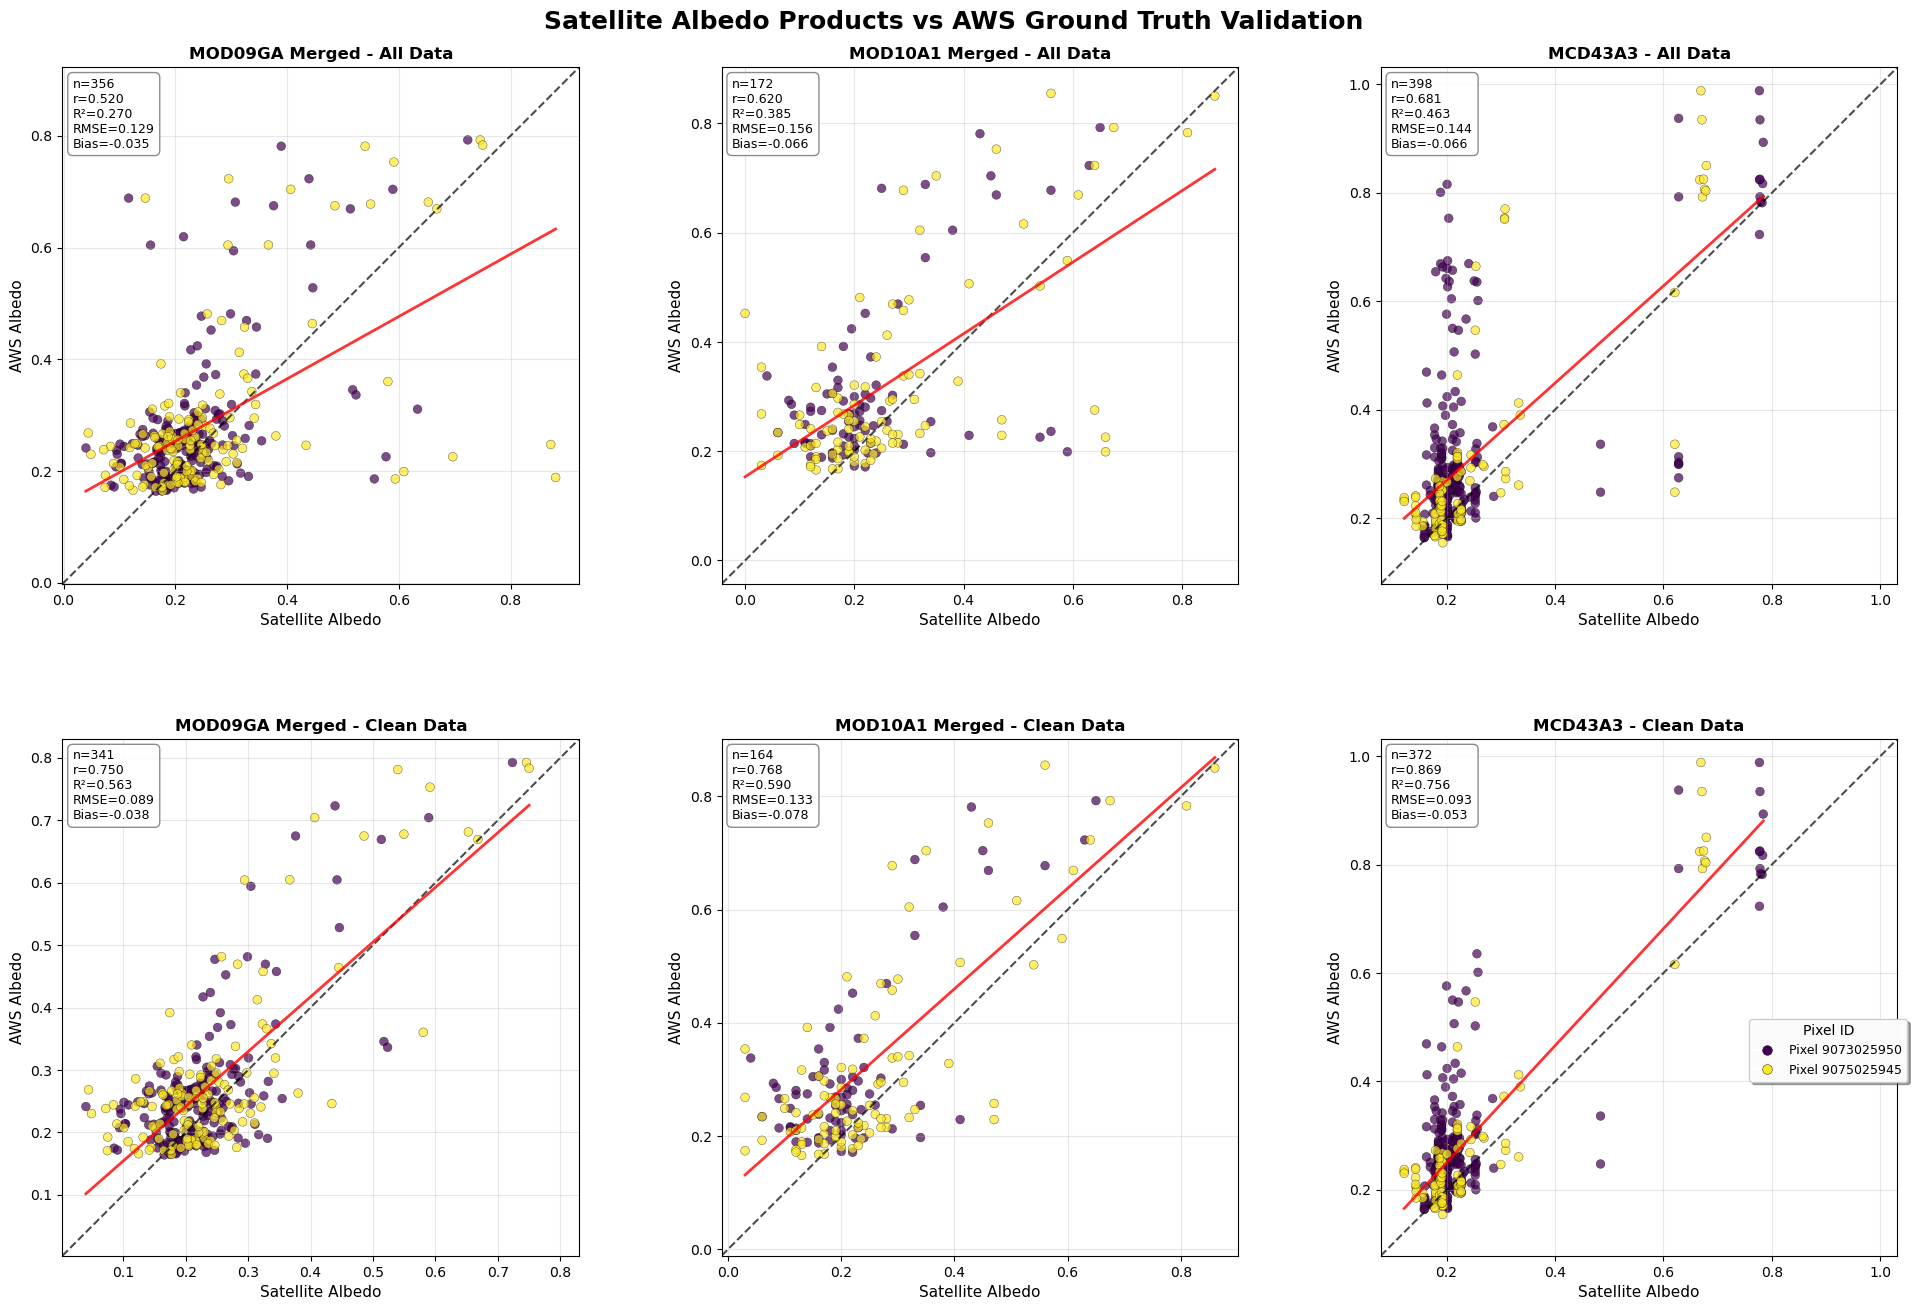


=== VALIDATION STATISTICS (outliers removed) ===
Product       | n    | r     | R²    | Bias  | RMSE  | MAE   
-----------------------------------------------------------------
MOD09GA Merged |  341 | 0.750 | 0.563 | -0.038 | 0.089 | 0.066
MOD10A1 Merged |  164 | 0.768 | 0.590 | -0.078 | 0.133 | 0.102
MCD43A3      |  372 | 0.869 | 0.756 | -0.053 | 0.093 | 0.062

Dataset: 1249/1298 points (3.8% outliers removed)


In [21]:
# Satellite Albedo vs AWS Validation Analysis
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Configuration
plt.style.use('default')
sns.set_palette("husl")

PRODUCTS = [
    {'name': 'merged_albedo_mod09ga', 'title': 'MOD09GA Merged', 'color': 'skyblue', 'edge': 'navy'},
    {'name': 'merged_albedo_mod10a1', 'title': 'MOD10A1 Merged', 'color': 'forestgreen', 'edge': 'darkgreen'},
    {'name': 'albedo_mcd43a3', 'title': 'MCD43A3', 'color': 'orange', 'edge': 'darkorange'}
]

# Global color mapping for pixel_id consistency
unique_pixel_ids = np.unique(df_with_flags['pixel_id'])
cmap = plt.get_cmap('viridis', len(unique_pixel_ids))
pixel_colors = {pid: cmap(i) for i, pid in enumerate(unique_pixel_ids)}

# Helper Functions
def calculate_stats(y_true, y_pred):
    """Calculate validation statistics"""
    mask = ~(np.isnan(y_true) | np.isnan(y_pred))
    if not np.any(mask):
        return {'bias': np.nan, 'r': np.nan, 'rmse': np.nan, 'mae': np.nan, 'n': 0}
    
    y_clean, pred_clean = y_true[mask], y_pred[mask]
    return {
        'bias': np.mean(pred_clean - y_clean),
        'r': np.corrcoef(y_clean, pred_clean)[0, 1],
        'rmse': np.sqrt(mean_squared_error(y_clean, pred_clean)),
        'mae': mean_absolute_error(y_clean, pred_clean),
        'n': len(y_clean)
    }

def plot_scatter(ax, x, y, title, stats, color='blue', edge='darkblue'):
    """Create scatter plot with regression and statistics"""
    # Clean data
    mask = ~(np.isnan(x) | np.isnan(y))
    x_clean, y_clean = x[mask], y[mask]
    
    # Scatter plot with pixel coloring
    pixel_ids = df_with_flags['pixel_id'].values[mask] if len(x) == len(df_with_flags) else df_no_outliers['pixel_id'].values[mask]
    colors = [pixel_colors[pid] for pid in pixel_ids]
    ax.scatter(x_clean, y_clean, c=colors, alpha=0.7, s=40, edgecolors='black', linewidth=0.3)
    
    # Set consistent square limits for all plots
    min_val = min(np.min(x_clean), np.min(y_clean))
    max_val = max(np.max(x_clean), np.max(y_clean))
    # Add padding for better visualization
    padding = (max_val - min_val) * 0.05
    lims = [min_val - padding, max_val + padding]
    
    # Reference line (1:1)
    ax.plot(lims, lims, 'k--', alpha=0.7, linewidth=1.5)  # 1:1 line
    
    # Regression line only across data range
    if len(x_clean) > 1:
        coeffs = np.polyfit(x_clean, y_clean, 1)
        x_data_range = [np.min(x_clean), np.max(x_clean)]
        y_reg_range = coeffs[0] * np.array(x_data_range) + coeffs[1]
        ax.plot(x_data_range, y_reg_range, 'r-', linewidth=2, alpha=0.8)
    
    # Statistics box
    r2 = stats['r']**2 if not np.isnan(stats['r']) else np.nan
    stats_text = f"n={stats['n']}\nr={stats['r']:.3f}\nR²={r2:.3f}\nRMSE={stats['rmse']:.3f}\nBias={stats['bias']:.3f}"
    ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, fontsize=9, va='top',
            bbox=dict(boxstyle='round,pad=0.4', facecolor='white', alpha=0.9, edgecolor='gray'))
    
    # Formatting with consistent square limits
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.set_xlabel('Satellite Albedo', fontsize=11)
    ax.set_ylabel('AWS Albedo', fontsize=11)
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.set_aspect('equal', adjustable='box')

# Main Plotting
fig, axes = plt.subplots(2, 3, figsize=(20, 14))
fig.suptitle('Satellite Albedo Products vs AWS Ground Truth Validation', fontsize=18, fontweight='bold', y=0.95)

# Create plots for each product
for i, product in enumerate(PRODUCTS):
    # All data (top row)
    stats_all = calculate_stats(df_with_flags['albedo_aws'].values, df_with_flags[product['name']].values)
    plot_scatter(axes[0, i], df_with_flags[product['name']].values, df_with_flags['albedo_aws'].values,
                f"{product['title']} - All Data", stats_all, product['color'], product['edge'])
    
    # Clean data (bottom row)
    stats_clean = calculate_stats(df_no_outliers['albedo_aws'].values, df_no_outliers[product['name']].values)
    plot_scatter(axes[1, i], df_no_outliers[product['name']].values, df_no_outliers['albedo_aws'].values,
                f"{product['title']} - Clean Data", stats_clean, product['color'], product['edge'])

# Legend for pixel IDs
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=pixel_colors[pid], 
                           markersize=7, markeredgecolor='black', markeredgewidth=0.3, label=f'Pixel {pid}') 
                 for pid in sorted(pixel_colors.keys())]
fig.legend(handles=legend_handles, title='Pixel ID', loc='lower right', fontsize=9, title_fontsize=10,
           frameon=True, fancybox=True, shadow=True, framealpha=0.97, bbox_to_anchor=(0.98, 0.18))

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.subplots_adjust(hspace=0.3, wspace=0.1)
plt.show()

# Summary Statistics Table
print("\n=== VALIDATION STATISTICS (outliers removed) ===")
print("Product       | n    | r     | R²    | Bias  | RMSE  | MAE   ")
print("-" * 65)
for product in PRODUCTS:
    stats = calculate_stats(df_no_outliers['albedo_aws'].values, df_no_outliers[product['name']].values)
    r2 = stats['r']**2 if not np.isnan(stats['r']) else np.nan
    print(f"{product['title']:12} | {stats['n']:4d} | {stats['r']:5.3f} | {r2:5.3f} | {stats['bias']:5.3f} | {stats['rmse']:5.3f} | {stats['mae']:5.3f}")

print(f"\nDataset: {len(df_no_outliers)}/{len(df_with_flags)} points ({(len(df_with_flags)-len(df_no_outliers))/len(df_with_flags)*100:.1f}% outliers removed)")

=== MOD09GA ENVIRONMENTAL ANALYSIS ===

NDSI Analysis:
  Data points: 285
  NDSI range: -0.144 to 0.933
  Residual range: -0.310 to 0.220
  Correlation with residuals: r=0.050 (p=0.404)
  Correlation with |residuals|: r=-0.121 (p=0.042)

Solar Zenith Analysis:
  Data points: 285
  Solar Zenith range: 28.800 to 56.150
  Residual range: -0.310 to 0.220
  Correlation with residuals: r=-0.317 (p=0.000)
  Correlation with |residuals|: r=0.405 (p=0.000)

Glacier Fraction Analysis:
  Data points: 285
  Glacier Fraction range: 0.659 to 0.969
  Residual range: -0.310 to 0.220
  Correlation with residuals: r=0.042 (p=0.478)
  Correlation with |residuals|: r=-0.120 (p=0.042)


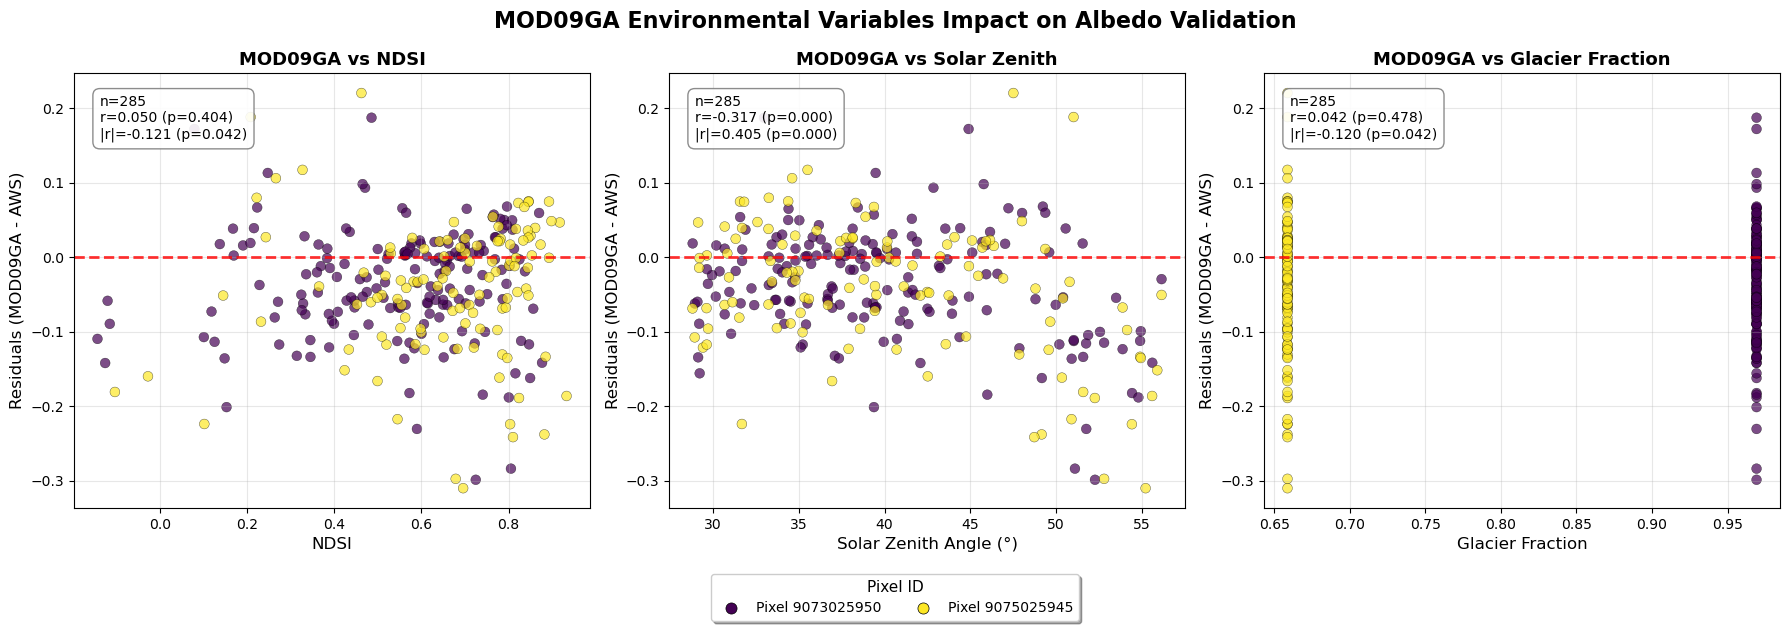


Analysis based on 1249 clean data points


In [27]:
# MOD09GA Environmental Impact Analysis: NDSI, Solar Zenith, and Glacier Fraction
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats

def analyze_environmental_impact(df, env_var, product_col, reference_col='albedo_aws'):
    """Analyze how environmental variables affect validation performance"""
    # Check if columns exist and remove NaN values
    mask = ~(np.isnan(df[env_var]) | np.isnan(df[product_col]) | np.isnan(df[reference_col]))
    data = df[mask].copy()
    
    if len(data) < 5:
        return None
    
    # Calculate residuals
    data['residuals'] = data[product_col] - data[reference_col]
    data['abs_residuals'] = np.abs(data['residuals'])
    
    return data

# MOD09GA Environmental Analysis
product_col = 'merged_albedo_mod09ga'
env_variables = [
    ('ndsi_mod09ga', 'NDSI', 'NDSI'),
    ('solar_zenith_mod09ga', 'Solar Zenith Angle (°)', 'Solar Zenith'),  
    ('glacier_fraction_mod09ga', 'Glacier Fraction', 'Glacier Fraction')
]

# Create 1x3 subplot for MOD09GA only
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('MOD09GA Environmental Variables Impact on Albedo Validation', fontsize=16, fontweight='bold')

print("=== MOD09GA ENVIRONMENTAL ANALYSIS ===")

for i, (env_var, xlabel, title) in enumerate(env_variables):
    if env_var in df_no_outliers.columns:
        data = analyze_environmental_impact(df_no_outliers, env_var, product_col)
        
        if data is not None and len(data) > 0:
            print(f"\n{title} Analysis:")
            print(f"  Data points: {len(data)}")
            print(f"  {title} range: {data[env_var].min():.3f} to {data[env_var].max():.3f}")
            print(f"  Residual range: {data['residuals'].min():.3f} to {data['residuals'].max():.3f}")
            
            # Scatter plot with pixel coloring
            colors = [pixel_colors[pid] for pid in data['pixel_id']]
            axes[i].scatter(data[env_var], data['residuals'], c=colors, alpha=0.7, s=50, 
                           edgecolors='black', linewidth=0.3)
            
            # Zero line
            axes[i].axhline(y=0, color='red', linestyle='--', alpha=0.8, linewidth=2)
            
            # Formatting
            axes[i].set_xlabel(xlabel, fontsize=12)
            axes[i].set_ylabel('Residuals (MOD09GA - AWS)', fontsize=12)
            axes[i].set_title(f'MOD09GA vs {title}', fontsize=13, fontweight='bold')
            axes[i].grid(True, alpha=0.3)
            
            # Add correlation statistics
            try:
                r, p = stats.pearsonr(data[env_var], data['residuals'])
                r_abs, p_abs = stats.pearsonr(data[env_var], data['abs_residuals'])
                
                stats_text = f'n={len(data)}\nr={r:.3f} (p={p:.3f})\n|r|={r_abs:.3f} (p={p_abs:.3f})'
                axes[i].text(0.05, 0.95, stats_text, transform=axes[i].transAxes, 
                           fontsize=10, va='top', ha='left',
                           bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.9, edgecolor='gray'))
                
                print(f"  Correlation with residuals: r={r:.3f} (p={p:.3f})")
                print(f"  Correlation with |residuals|: r={r_abs:.3f} (p={p_abs:.3f})")
                
            except Exception as e:
                print(f"  Could not calculate correlations: {e}")
        else:
            axes[i].text(0.5, 0.5, f'Insufficient data\nfor {title} analysis', 
                        transform=axes[i].transAxes, ha='center', va='center', fontsize=12)
            axes[i].set_title(f'MOD09GA vs {title}', fontsize=13)
            print(f"\n{title}: Insufficient data for analysis")
    else:
        axes[i].text(0.5, 0.5, f'{title} column\nnot found', 
                    transform=axes[i].transAxes, ha='center', va='center', fontsize=12)
        axes[i].set_title(f'MOD09GA vs {title}', fontsize=13)
        print(f"\n{title}: Column '{env_var}' not found")

# Add pixel legend
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=pixel_colors[pid], 
                           markersize=8, markeredgecolor='black', markeredgewidth=0.5, label=f'Pixel {pid}') 
                 for pid in sorted(pixel_colors.keys())]
fig.legend(handles=legend_handles, title='Pixel ID', loc='lower center', ncol=len(pixel_colors), 
           fontsize=10, title_fontsize=11, frameon=True, fancybox=True, shadow=True, 
           bbox_to_anchor=(0.5, -0.05))

plt.tight_layout()
plt.subplots_adjust(bottom=0.15)
plt.show()

print(f"\nAnalysis based on {len(df_no_outliers)} clean data points")